# Facies Classification Using Machine Learning
##### Rusell Menezes | Geo - Data Scientist

This is my attempt to use a machine learning algorothm (Deep Neural Network) to predict rock facies from well logs.
In 2016, SEG organized a machine Learning contest to see who could come up with the most accurate model which could predict rock facies from well logs. The winner model had an average F1 socre of 0.63. Using a basic deep neural network was able to achieve a score of 0.51 (which is not vey good) on the blind well data. In the notebooks to come, I will try different techniques (feature engineering, feature augmentation, different classification algorothms, etc.) to beat this score and to get an F1 score greater than 0.95. This notebook makes use of some elements from Brendan Hall's notebook.

This well data is from the Council Grove gas reservoir in Southwest Kansas. The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas. This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector. Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate.

The seven predictor variables are:

Five wire line log curves include gamma ray (GR), resistivity logging (ILD_log10), photoelectric effect (PE), neutron-density porosity difference and average neutron-density porosity (DeltaPHI and PHIND). Note, some wells do not have PE.
Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are:

1. Nonmarine sandstone
2. Nonmarine coarse siltstone
3. Nonmarine fine siltstone
4. Marine siltstone and shale
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import set_option
set_option("display.max_rows", 10)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Importing the log data from csv

In [96]:
data = pd.read_csv('training_data.csv')

#### Seperating logs from the well 'Shankle' which will be used as blind test. Training data will be used to build the model.

In [97]:
blind = data[data['Well Name'] == 'SHANKLE']
training_data = data[data['Well Name'] != 'SHANKLE']
training_data.sample(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
218,2,B3 SH,SHRIMPLIN,2902.0,76.050,0.479,7.500,11.375,3.500,1,0.200
1136,8,B2 LM,LUKE G U,2718.5,22.980,0.913,1.100,6.750,5.000,2,0.316
1012,4,A1 LM,LUKE G U,2656.5,85.680,0.614,9.600,14.800,3.700,2,0.418
2436,8,A1 LM,NEWBY,2861.5,49.350,0.919,-1.200,4.100,3.600,2,0.659
1199,2,B4 SH,LUKE G U,2750.0,61.980,0.530,2.500,11.450,3.200,1,0.348
9,3,A1 SH,SHRIMPLIN,2797.5,76.890,0.615,16.900,14.220,3.500,1,0.787
1155,3,B3 SH,LUKE G U,2728.0,82.810,0.212,7.600,19.500,2.700,1,0.657
2606,2,B3 SH,NEWBY,2946.5,72.240,0.589,2.900,12.450,3.300,1,0.571
2559,4,B1 LM,NEWBY,2923.0,86.090,0.616,5.200,8.900,3.400,2,0.053
3136,9,B5 LM,CHURCHMAN BIBLE,3075.0,45.719,0.516,0.398,16.106,5.352,2,0.300


#### Allocating colors and abbreviations to the different facies and appening them to the data table under column 'Facies Labels'.

In [118]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone

facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

facies_colmap = dict(zip(facies_labels, facies_colors))

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [89]:
training_data.sample(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
947,2,A1 SH,LUKE G U,2624.0,54.010,0.483000,4.500,11.650,3.400,1,0.491,CSiS
2565,2,B2 SH,NEWBY,2926.0,80.200,0.465000,7.000,24.500,3.100,1,0.556,CSiS
1770,8,B5 LM,CROSS H CATTLE,2771.5,91.434,0.597914,4.800,11.300,4.397,2,0.550,PS
2125,2,B4 SH,NOLAN,2975.0,83.938,0.526000,3.957,16.355,2.709,1,0.958,CSiS
1423,1,A1 SH,CROSS H CATTLE,2594.5,60.198,-0.015923,2.300,19.950,2.556,1,0.408,SS
933,2,A1 SH,LUKE G U,2617.0,107.220,0.483000,11.300,15.750,3.300,1,0.755,CSiS
1772,8,B5 LM,CROSS H CATTLE,2772.5,85.405,0.599009,4.000,10.100,4.544,2,0.450,PS
3157,7,B5 LM,CHURCHMAN BIBLE,3085.5,128.000,0.641000,7.388,10.874,3.330,2,0.033,D
1600,1,B2 SH,CROSS H CATTLE,2685.5,75.510,0.625827,9.000,8.700,3.652,1,0.407,SS
2122,8,B3 LM,NOLAN,2973.5,28.328,0.565000,2.510,8.281,3.936,2,0.167,PS


#### Plotting the well Nolan to visualize the data

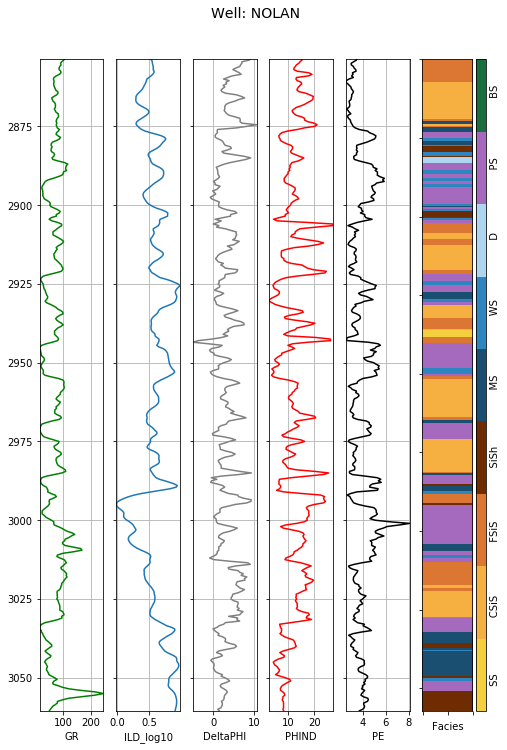

In [104]:
from log_plot import make_facies_log_plot
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'NOLAN'],
    facies_colors)

#### In order to look at how the facies are represented by the entire training set, we can plot histogram of the number of training examples for each facies class.

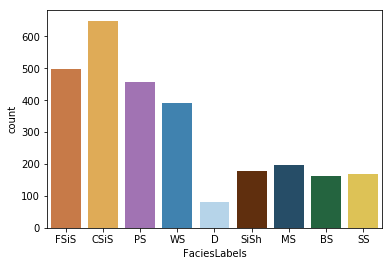

In [119]:
import seaborn as sns

sns.countplot(x = 'FaciesLabels', palette = facies_colmap, data = training_data)
plt.show()

#### We can crossplot the logs against each other to see their relationships

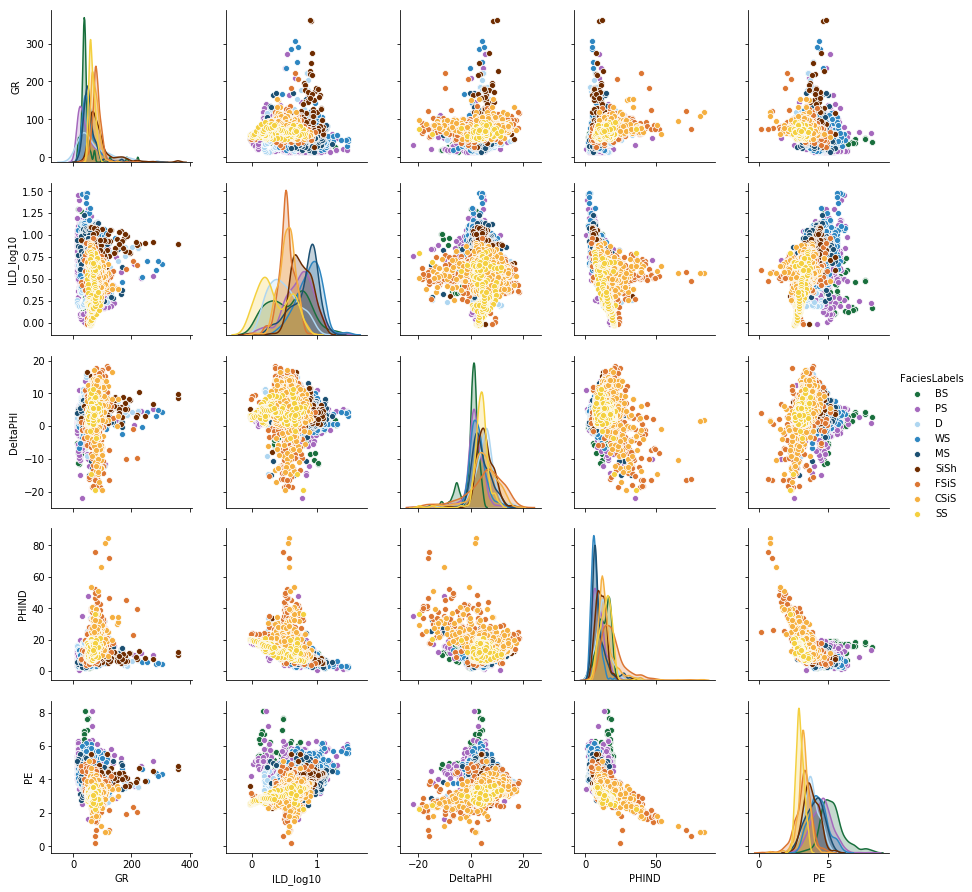

In [122]:
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'], axis=1),
            hue='FaciesLabels', palette = facies_colmap, hue_order = list(reversed(facies_labels)))

plt.show()

#### Preparing data for training

In [90]:
#Removing Categorical Data
X = training_data.iloc[:, 3:-1].values
y = training_data.iloc[:, -1].values

In [91]:
# Encoding categorical data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
warnings.filterwarnings('ignore')
onehotencoder = OneHotEncoder(categorical_features = [6])
X = onehotencoder.fit_transform(X).toarray()

labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [92]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [93]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Building the Neural Network using Keras along with Tensorflow
#### I'm using GridSearchCV to tune the hyperparameters and 10 fold cross validation to prevenr overfitting.

In [20]:
#Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units= 7, kernel_initializer= 'uniform', activation = 'relu', input_dim = 9))
    classifier.add(Dense(units=7, kernel_initializer= 'uniform', activation = 'relu'))
    classifier.add(Dense(units=9, kernel_initializer= 'uniform', activation = 'softmax'))
    classifier.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return classifier
classifier  = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size':[5, 10],
              'epochs':[100, 600],
              'optimizer':['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=parameters,
                           scoring='accuracy',
                           cv = 10)

#from keras_tqdm import TQDMNotebookCallback
#grid_search = grid_search.fit(X_train, y_train, verbose=0,
#                              callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True)])

Using TensorFlow backend.


#### I've trained the model and pickeled it. I'll load this model below

In [34]:
#SaveModel
from sklearn.externals import joblib
joblib_file = "joblib_model.pkl"
grid_search = joblib.load(joblib_file)

In [35]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
#results = grid_search.cv_results_

print('The best hyperparameters for the model are {}'.format(best_parameters))
print('The best best accuracy achieved is {0:.2f} %'.format(best_accuracy * 100))

The best hyperparameters for the model are {'batch_size': 5, 'epochs': 600, 'optimizer': 'adam'}
The best best accuracy achieved is 61.94 %


#### Validating the model with test data and using a confusion matrix to visualize the results

In [76]:
y_pred = grid_search.predict(X_test)

from sklearn.metrics import confusion_matrix
from classification_utilities3 import display_cm, display_adj_cm
cm = confusion_matrix(y_test, y_pred)

display_cm(cm, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total

     True
       SS    10                             4                      14
     CSiS          40          14                 4                58
     FSiS                             1     7           2     1    11
     SiSh          14          24                 2                40
       MS           1     1          10     4           3    11    30
       WS     3                       2    33           2    11    51
        D           7                            17                24
       PS           1                                  12     3    16
       BS     1                       4     6           2    22    35

Precision  0.71  0.63  0.00  0.63  0.59  0.61  0.74  0.57  0.46  0.59

   Recall  0.71  0.69  0.00  0.60  0.33  0.65  0.71  0.75  0.63  0.60

       F1  0.71  0.66  0.00  0.62  0.43  0.63  0.72  0.65  0.53  0.59



#### To test our blind well against the model

In [100]:
#Preparing data from blind well to be tested
blind = blind.iloc[:, 3:].values
blind = onehotencoder.transform(blind).toarray()
blind = sc.transform(blind)

#Evaluating against the model
predictions = grid_search.predict(blind)
prediction_ = labelencoder.inverse_transform(predictions)

In [101]:
#Preparing true well lables to compare against blind test
training_data_1 = data
training_data_1.loc[:,'FaciesLabels'] = training_data_1.apply(lambda row: label_facies(row, facies_labels), axis=1)
test_well = training_data_1[training_data_1['Well Name'] == 'SHANKLE']
test_well_Facies = np.array(test_well.FaciesLabels)

#### Confusion matrix for blind well

In [102]:
cm_b = confusion_matrix(test_well_Facies, prediction_)

display_cm(cm_b, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total

     True
       SS                                                           0
     CSiS          63          21                 5                89
     FSiS                 7     1     1     4           4          17
     SiSh          58          57                 2               117
       MS                 4           4                 6     5    19
       WS     1           1           2    18                18    40
        D          64                            25                89
       PS                                               1     6     7
       BS                                   7          12    52    71

Precision  0.00  0.34  0.58  0.72  0.57  0.62  0.78  0.04  0.64  0.61

   Recall  0.00  0.71  0.41  0.49  0.21  0.45  0.28  0.14  0.73  0.51

       F1  0.00  0.46  0.48  0.58  0.31  0.52  0.41  0.07  0.68  0.51



#### Plotting real facies against predicted

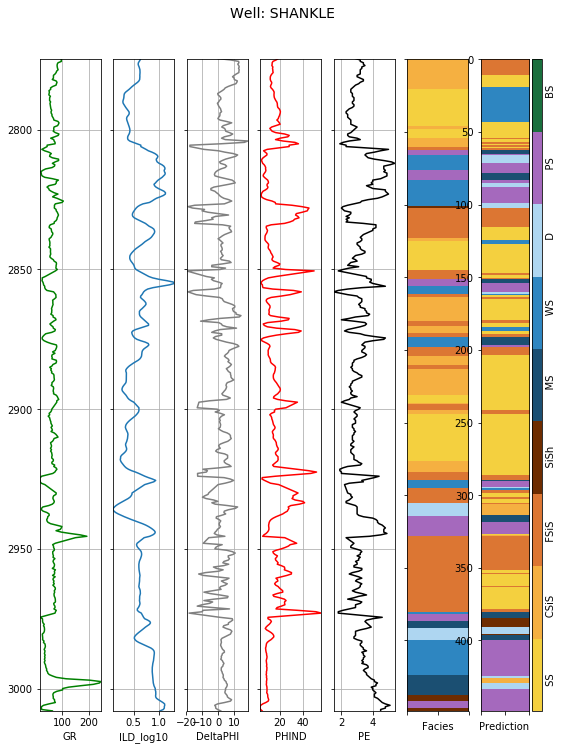

In [103]:
test_well['Prediction'] = predictions

from log_plot_compare import compare_facies_plot
compare_facies_plot(test_well, 'Prediction', facies_colors)